In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import json
%matplotlib inline
plt.style.use(["dark_background"])

In [63]:
# Load the metadata.csv file.
metadata = pd.read_csv("/Users/alejandrosanchezaristizabal/Desktop/metadata.csv")
metadata.head()

,img_path,label,set
0,/Users/alejandrosanchezaristizabal/Desktop/ima...,1,train
1,/Users/alejandrosanchezaristizabal/Desktop/ima...,1,train
2,/Users/alejandrosanchezaristizabal/Desktop/ima...,1,train
3,/Users/alejandrosanchezaristizabal/Desktop/ima...,1,train
4,/Users/alejandrosanchezaristizabal/Desktop/ima...,1,train


In [64]:
# Load the metadata_one_per_label.csv file.
metadata_one_per_label = pd.read_csv("/Users/alejandrosanchezaristizabal/Desktop/metadata_one_per_label.csv")
metadata_one_per_label.head()

,Unnamed: 0,img_path,label,set
0,0,/Users/alejandrosanchezaristizabal/Desktop/ima...,1,train
1,10,/Users/alejandrosanchezaristizabal/Desktop/ima...,4,valid
2,20,/Users/alejandrosanchezaristizabal/Desktop/ima...,3,test
3,30,/Users/alejandrosanchezaristizabal/Desktop/ima...,2,test
4,40,/Users/alejandrosanchezaristizabal/Desktop/ima...,0,train


In [65]:
def preprocess_image(image):
    """Resize and normalize the image."""
    image = tf.image.resize(image, size=(64, 64))
    image = image / 255.0
    return image

def augment_image(image):
    """Augment the image to generate more data."""
    return image

def make_dataset(sources, training=False, batch_size=1, num_epochs=1, num_parallel_calls=1, 
                 shuffle_buffer_size=None):
    """
    Returns an operation to iterate over the dataset specified in sources

    Args:
        sources (list): a list of (filepath, label_id) pairs.
        training (bool): whether to apply certain processing steps defined only in training mode 
            (e.g. shuffle).
        batch_size (int): number of elements the resulting tensor should have.
        num_epochs (int): number of epochs to repeat the dataset.
        num_parallel_calls (int): number of parallel calls to use in map operations.
        shuffle_buffer_size (int): number of elements from this dataset from which the new 
            dataset will sample.

    Returns:
        A tf.data.Dataset object. It will return a tuple images of shape [N, H, W, CH] and labels 
        shape [N, 1].
    """
    def load(row):
        filepath = row["image"]
        img = tf.io.read_file(filepath)
        img = tf.io.decode_jpeg(img)
        return img, row["label"]

    if shuffle_buffer_size is None:
        shuffle_buffer_size = batch_size*4

    images, labels = sources["img_path"].values, sources["label"].values 
    
    ds = tf.data.Dataset.from_tensor_slices({"image": images, "label": labels}) 

    if training:
        ds = ds.shuffle(shuffle_buffer_size)
    
    ds = ds.map(load, num_parallel_calls=num_parallel_calls)
    ds = ds.map(lambda x, y: (preprocess_image(x), y))
    
    if training:
        ds = ds.map(lambda x, y: (augment_image(x), y))
        
    ds = ds.repeat(count=num_epochs)
    ds = ds.batch(batch_size=batch_size)
    ds = ds.prefetch(1)

    return ds

In [66]:
data_set = make_dataset(metadata, training=True, batch_size=3, num_epochs=1, num_parallel_calls=1, 
                        shuffle_buffer_size=None)
data_set = iter(data_set)
data_set

In [67]:
data_set_one_per_label = make_dataset(metadata_one_per_label, training=True, batch_size=3, 
                                      num_epochs=1, num_parallel_calls=1, shuffle_buffer_size=None)
data_set_one_per_label = iter(data_set_one_per_label)
data_set_one_per_label

In [68]:
def imshow_batch_of_three(batch, show_label=True):
    """Shows a sample of the images on the TFDataSet."""
    with open("/Users/alejandrosanchezaristizabal/Desktop/label_map.json") as label_map:
        label_to_map = json.load(label_map)
    image_batch = batch[0].numpy()
    label_batch = batch[1].numpy()
    fig, axarr = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for i in range(3):
        img = image_batch[i, ...]
        axarr[i].imshow(img)
        if show_label:
            axarr[i].set(xlabel="label = {} - {}".format(label_batch[i], 
                                                         label_to_map[str(label_batch[i])]))

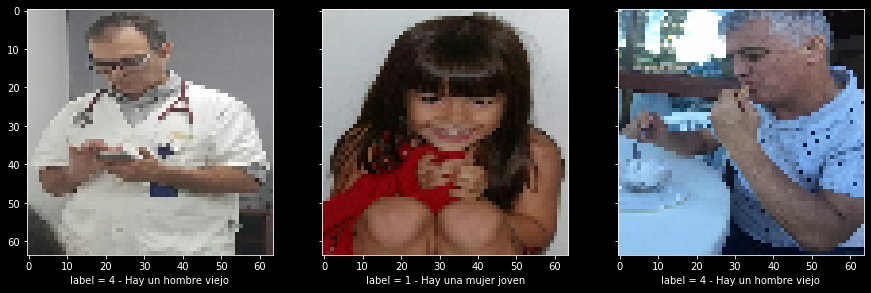

In [69]:
imshow_batch_of_three(next(data_set))